## Example: steady advection-diffusion-reaction on a rectangle

c.f. Donea & Huerta, *Finite Element Methods for Flow Problems* $\S 2.6.5$

$$
\mathbb{S}=
\begin{cases}
\Omega = [-1/2, 1/2] \times [-1/2, 1/2] \\
u_0(x,y) = \tfrac{1}{4}(1+\cos(\pi(x-x_0)))(1+\cos(\pi(y-y_0)))~\text{if}~(x-x_0)^2+(y-y_0)^2\leq1\\
u_0(x,y) = 0~\text{if}~(x-x_0)^2+(y-y_0)^2>1\\
u_{\text{I}}=0 \\
\textbf{a} = \begin{pmatrix}
-y \\
x
\end{pmatrix}
\end{cases}
$$

In [ ]:
import numpy as np
from ufl.core.expr import Expr
from ufl import SpatialCoordinate, as_vector, cos, sqrt
from lucifex.mesh import rectangle_mesh
from lucifex.fem import Function, Constant
from lucifex.solver import bvp, BoundaryConditions, BoundaryValueProblem
from lucifex.viz import plot_colormap, plot_line
from lucifex.io import write, get_ipynb_file_name
from lucifex.utils import cross_section
from lucifex.pde.advection_diffusion import (
    steady_advection_diffusion, 
    steady_advection_diffusion_dg,
)

def create_solver(
    Lx: float,
    Ly: float,
    Nx: int,
    Ny: int,
    y_inflow: float,
    u_inflow: float,
    d: float, 
    a: float,
    theta: float,
    dg: tuple[float, float] | None,
) -> BoundaryValueProblem:
    mesh = rectangle_mesh(Lx, Ly, Nx, Ny)
    theta_rad = theta * np.pi / 180
    ax = a * np.cos(theta_rad)
    ay = a * np.sin(theta_rad)
    a = Constant(mesh, (ax, ay), name='a')
    d = Constant(mesh, d, name='d')
    bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[1], 0.0),
        ('dirichlet', lambda x: np.isclose(x[0], 0) & (x[1] < y_inflow), 0.0),
        ('dirichlet', lambda x: np.isclose(x[0], 0) & (x[1] >= y_inflow), u_inflow),
        ('neumann', lambda x: x[0] - Lx, 0.0),
        ('neumann', lambda x: x[1] - Ly, 0.0),
    )

    if dg:
        u = Function((mesh, 'DP', 1), name='u')
        return bvp(steady_advection_diffusion_dg)(u, a, d, *dg, bcs=bcs)
    else:
        u = Function((mesh, 'P', 1), name='u')
        return bvp(steady_advection_diffusion, bcs)(u, a, d)
    

Lx = 1.0
Ly = 1.0
Nx = 50
Ny = 50
u_inflow = 1.0
y_inflow = 0.5
d = 1e-3
a = 1.0
theta = 30.0

u_cg_solver = create_solver(Lx, Ly, Nx, Ny, y_inflow, u_inflow, d, a, theta, None)
u_cg_solver.solve()
u_cg = u_cg_solver.solution

u_dg_solver = create_solver(Lx, Ly, Nx, Ny, y_inflow, u_inflow, d, a, theta, (10.0, 10.0))
u_dg_solver.solve()
u_dg = u_dg_solver.solution

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'DG'}, xlabel='$x$', ylabel='$y$'>)

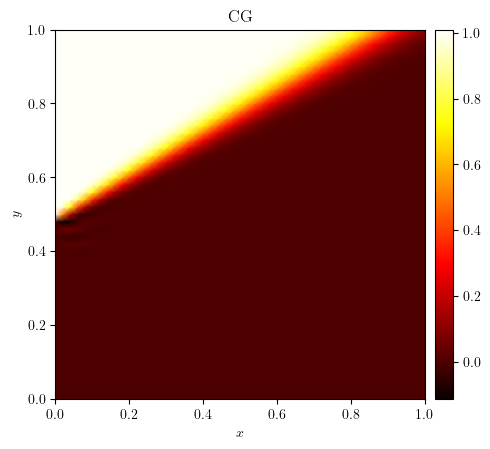

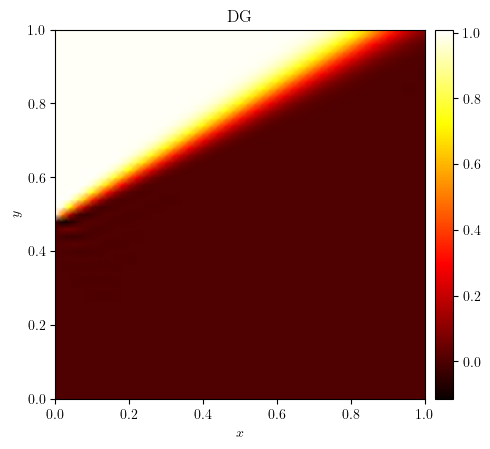

In [2]:
plot_colormap(u_cg, title='CG')
plot_colormap(u_dg, title='DG')


(<Figure size 640x480 with 1 Axes>, <Axes: >)

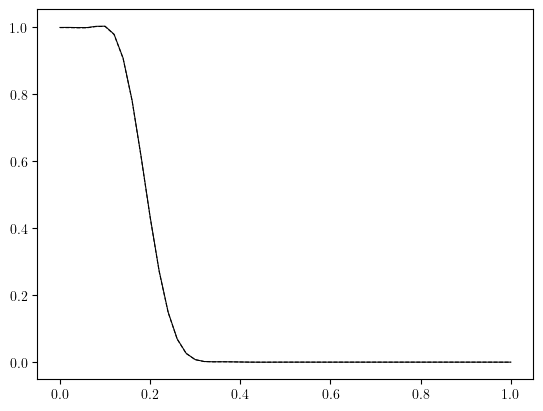

: 

In [ ]:
y_target = 0.6
ucg_x_axis, ucg_x, y_value = cross_section(u_cg, 'y', y_target)
udg_x_axis, udg_x, y_value = cross_section(u_dg, 'y', y_target)
plot_line(
    [(ucg_x_axis, ucg_x), (udg_x_axis, udg_x)]
)
